# CellRank Analysis of mouse intestinal crypt cells TE006

### Import Libraries

In [3]:
import sys
import cellrank as cr
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter("ignore", category=UserWarning)

### Parameters Setting

In [4]:
# a.1) setup path to data-containing folder and savings and parameters
base_path = "/Users/av2729/Clouds/Dropbox/isc-data-at-cell/"
input_dir = os.path.join(base_path,"input")
figures_dir = os.path.join(base_path,"figures")

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

n_macro_CytoTRACE = 8 # number of macrostates 

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

### Input Data Definition

In [9]:
# Counts data (exported from Seurat@RNA assay)
counts_h5ad = os.path.join( input_dir , "TE006-cells-original-data.h5ad" )
# Metadata for TE001 from VIPER analysis
metadata_csv = os.path.join(input_dir , "TE006-metadata-ingest-with-cluster-ids-with-paneth-cluster.csv" )
# # Metadata for MRs lineage enrichment for TE001 (three lineages from step 1 of iterative clustering algorihtm)
# mrs_enrichment_csv = os.path.join(input_dir , "TE001-mrs-enrichment-table-3D-plot.csv" )

### Load Datasets and Processed Data

In [18]:
#Load counts data and metadata for TE006. Setup UMAP coordinates for UMAP visualization 
# a.3) load counts data 
counts_h5ad = os.path.join( input_dir , "TE006-cells-original-data.h5ad" )
adata = sc.read_h5ad(counts_h5ad) # load in object

# a.4) load metadata for TE006 
metadata_csv = os.path.join( input_dir , "TE006-metadata-ingest-with-cluster-ids-with-paneth-cluster.csv" )
metadata = pd.read_csv(metadata_csv)
metadata = metadata.rename(columns={'index': 'cell_id'})

metadata_csv_umap = os.path.join( input_dir , "ablation-metadata-ingest.csv" )
metadata_umap = pd.read_csv(metadata_csv_umap)
metadata_umap = metadata_umap[['cell_id','UMAP_1','UMAP_2']]

# a.5) process metadata in adata
cells_to_analyze = metadata['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata
adata.obs['cell_id'] = adata.obs_names

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left') # merge metadata and include into counts object
adata.obs = pd.merge(adata.obs, metadata_umap, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

#adata.obs_names = adata.obs['cell_id']

# a.6) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1','UMAP_2']]) 
adata.obsm['X_umap'] = umap_coordinates


# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

print("adata contains the counts for the TE006 dataset")
#counts = adata.raw.to_adata() # the adata already contains the counts matrix

adata contains the counts for the TE006 dataset


## CellRank2 analysis with CytoTRACE Kernel
Import CellRank2 kernel, compute CytoTRACE score with CellRank (sparse), and compute transition matrix for CellRank2 analysis

### Processing counts for CellRank analysis

In [19]:
print("Preprocessing counts matrix for CellRank 2 analysis")
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Preprocessing counts matrix for CellRank 2 analysis


In [20]:
### c) CytoTRACE kernel
# c.1) Setup kernel
print("Working with CytoTRACE kernel")
from cellrank.kernels import CytoTRACEKernel
import scvelo as scv
# CytoTRACE by default uses imputed data - a simple way to compute
# k-NN imputed data is to use scVelo's moments function.
# However, note that this function expects `spliced` counts because
# it's designed for RNA velocity, so we're using a simple hack here:
if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
    adata.layers['spliced'] = adata.X
    adata.layers['unspliced'] = adata.X
scv.pp.moments(adata) # hack for CytoTRACEkernel

ctk = CytoTRACEKernel(adata) # initialize the CellRank2 kernel

# c.2) compute transition matrix
ctk = ctk.compute_cytotrace().compute_transition_matrix(threshold_scheme="soft",nu=0.5) # compute transition matrix


Working with CytoTRACE kernel
Normalized count data: X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `32287` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)
Computing transition matrix based on pseudotime


  0%|          | 0/6977 [00:00<?, ?cell/s]

    Finish (0:00:04)


Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:01)
saving figure to file /Users/av2729/Clouds/Dropbox/isc-data-at-cell/figures/TE006-CytoTRACE_differentiation_pa_clusters.svg


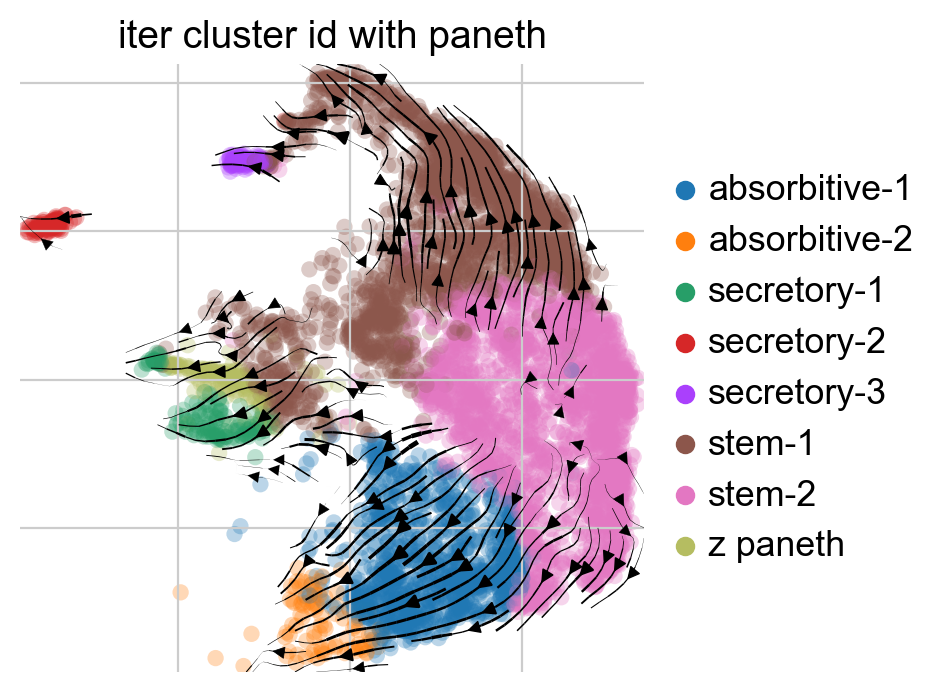

In [21]:
differentiation_figure = os.path.join( figures_dir , "TE006-CytoTRACE_differentiation_pa_clusters.svg" )
ctk.plot_projection(basis="umap", color="iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)


Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/av2729/opt/anaconda3/envs/single-cell-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


saving figure to file /Users/av2729/Clouds/Dropbox/isc-data-at-cell/figures/TE006-CytoTRACE_differentiation_pa_clusters_cytotrace.svg


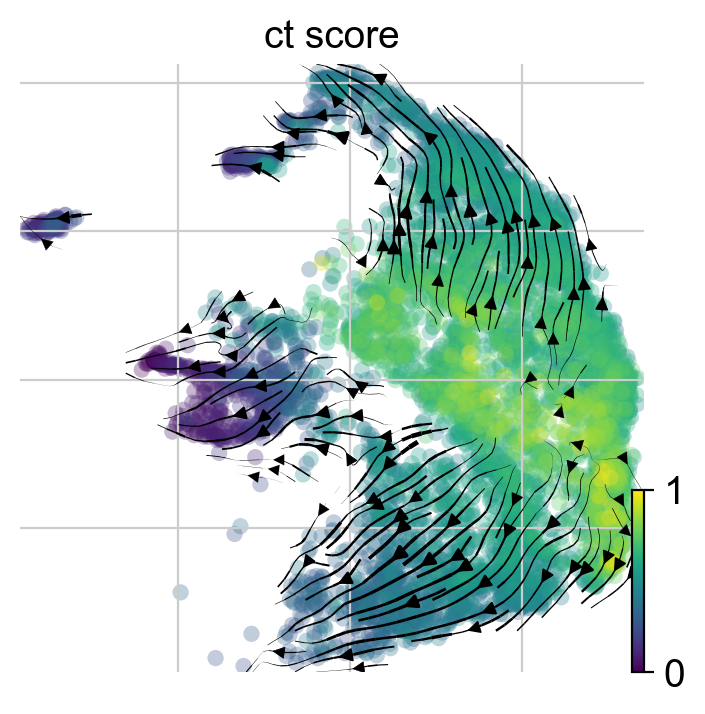

In [22]:
differentiation_figure = os.path.join( figures_dir , "TE006-CytoTRACE_differentiation_pa_clusters_cytotrace.svg" )
ctk.plot_projection(basis="umap", color="ct_score", cmap = "viridis" ,
                    legend_loc="right", save=differentiation_figure, show=True)
